In [1]:
import os

if 'utils.py' not in os.listdir():
  !wget https://raw.githubusercontent.com/ChiThang-50Cent/text-recognizer-labs/main/base/utils.py

--2023-10-20 15:21:43--  https://raw.githubusercontent.com/ChiThang-50Cent/text-recognizer-labs/main/base/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2454 (2.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.40K  --.-KB/s    in 0s      

2023-10-20 15:21:43 (45.2 MB/s) - ‘utils.py’ saved [2454/2454]



In [2]:
import torch
import torchvision
import utils as f
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader

In [3]:
train_set, valid_set, test_set = f.get_EMNIST_datasets()

100%|██████████| 561753746/561753746 [00:05<00:00, 96023343.92it/s] 


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw
train_size: 101520, valid_size: 11280, test_size: 18800


In [4]:
f.set_all_seed(42)

device = f.get_device()
print(device)

cuda


In [5]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

torch.Size([64, 1, 28, 28])


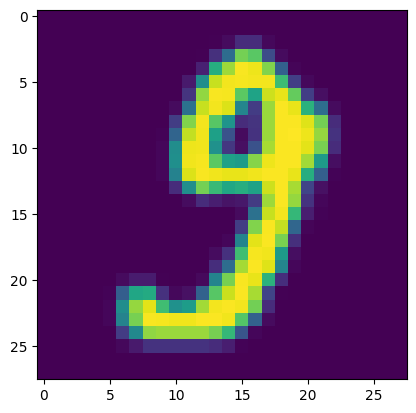

47 0.0 46.0


In [6]:
import matplotlib.pyplot as plt

check = np.array([])
for x, y in test_loader:
  check = np.concatenate((check, y), axis=None)
for x, y in test_loader:
  print(x.shape)
  img = x[0].permute(2, 1, 0)
  plt.imshow(img)
  plt.show()
  break

print(len(set(check)), min(check), max(check))

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )

        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [8]:
class ResNet(nn.Module):
    def __init__(self, input_channel, block, layers, num_classes=47):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(input_channel, 64, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU()
        # )

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)

        # self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=1, stride=1)

        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, n_blocks, stride):

        dowsample = None
        if stride != 1 or self.inplanes != planes:
            dowsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )

        layer = []
        layer.append(block(self.inplanes, planes, stride, dowsample))
        self.inplanes = planes

        for _ in range(1, n_blocks):
            layer.append(block(self.inplanes, planes))

        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.fc2(out)

        return out


In [9]:
img_size = 28
fc_dim = 128
conv_dim = 64
num_classes = 47
input_dim = 1

In [43]:
ResNet18 = ResNet(input_dim, ResidualBlock, [2, 2, 2, 2])
ResNet18.cuda()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
# optimizer = optim.Adam(ResNet18.parameters(), lr=5e-2)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=0.5)

In [45]:
f.training_loop(n_epochs=8,
                model=ResNet18,
                train_loader=train_loader,
                val_loader=valid_loader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                scheduler=None,
                device=device)

Epoch 1 in 8 total. Train loss 0.61. Valid loss 0.42. Valid acc 0.85.
Epoch 2 in 8 total. Train loss 0.39. Valid loss 0.40. Valid acc 0.86.
Epoch 3 in 8 total. Train loss 0.35. Valid loss 0.32. Valid acc 0.88.
Epoch 4 in 8 total. Train loss 0.33. Valid loss 0.35. Valid acc 0.88.
Epoch 5 in 8 total. Train loss 0.32. Valid loss 0.38. Valid acc 0.87.
Epoch 6 in 8 total. Train loss 0.31. Valid loss 0.36. Valid acc 0.87.
Epoch 7 in 8 total. Train loss 0.30. Valid loss 0.35. Valid acc 0.88.
Epoch 8 in 8 total. Train loss 0.29. Valid loss 0.32. Valid acc 0.88.


In [46]:
ResNet18.eval()
ResNet18.cpu()

y_pred = []
y_true = []

with torch.no_grad():
  for X, y in test_loader:

    y_hat = ResNet18(X)

    y_pred.append(y_hat.softmax(dim=1).argmax(dim=1).numpy())
    y_true.append(y.numpy())

y_pred = np.concatenate(y_pred, axis=None)
y_true = np.concatenate(y_true, axis=None)

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.89      0.72       400
           1       0.52      0.81      0.63       400
           2       0.92      0.88      0.90       400
           3       0.99      0.97      0.98       400
           4       0.91      0.94      0.93       400
           5       0.88      0.94      0.91       400
           6       0.93      0.94      0.93       400
           7       0.97      0.99      0.98       400
           8       0.94      0.94      0.94       400
           9       0.75      0.67      0.71       400
          10       0.96      0.98      0.97       400
          11       0.95      0.96      0.96       400
          12       0.96      0.96      0.96       400
          13       0.95      0.92      0.93       400
          14       0.99      0.95      0.97       400
          15       0.66      0.61      0.63       400
          16       0.90      0.97      0.94       400
          17       0.98    